Dispositivo configurado: cuda
GPU disponible: True
GPU detectada: NVIDIA GeForce RTX 4060 Laptop GPU
CARGA DE DATOS

📊 Dimensiones de los datasets:
   - Train: (3680, 20) (3,680 registros, 20 columnas)
   - Test: (520, 19) (520 registros, 19 columnas)
   - Submission: (520, 2)

📅 Rango temporal:
   - Train: 2015 - 2021
   - Test: 2022 - 2022

🏘️  Número de barrios:
   - Train: 10 barrios únicos
   - Test: 10 barrios únicos

📋 Columnas en train:
   ['id', 'id_bar', 'anio', 'semana', 'ESTRATO', 'area_barrio', 'dengue', 'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min', 'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temperatura_min']

📋 Columnas en test:
   ['id', 'id_bar', 'anio', 'semana', 'ESTRATO', 'area_barrio', 'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min', 'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temp


📅 Estadísticas por año:
         sum  mean   std
anio                    
2015  2516.0  4.75  3.99
2016  3226.0  6.09  4.77
2017   517.0  0.99  1.21
2018   261.0  0.50  0.73
2019   480.0  0.92  1.25
2020  1735.0  3.27  3.61
2021   868.0  1.64  1.84


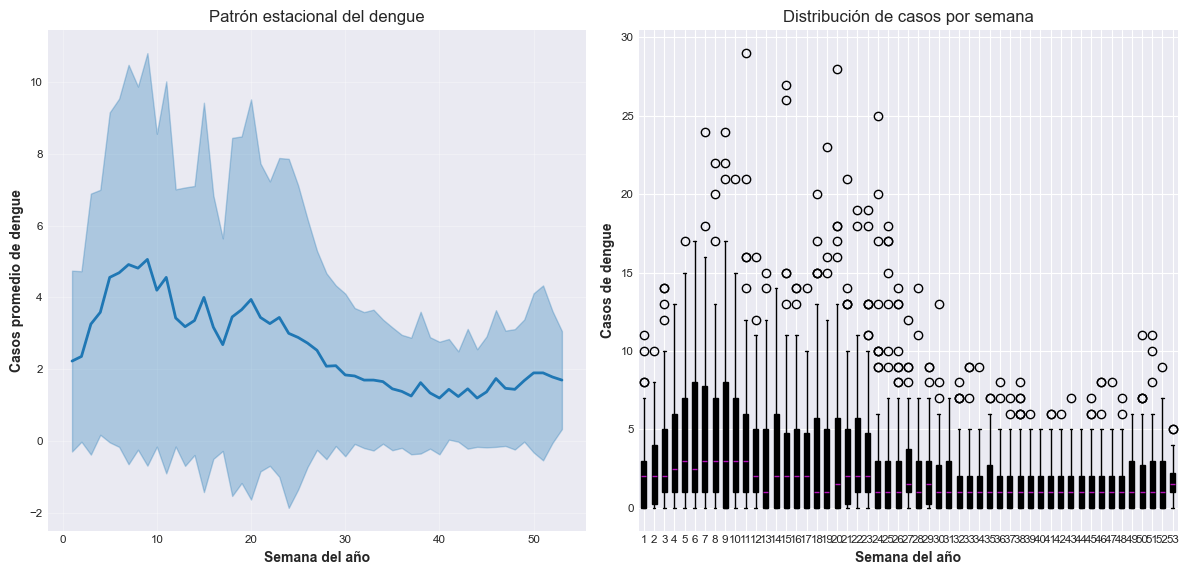


ANÁLISIS POR BARRIO

🏘️  Top 10 barrios con más casos de dengue:
        count     sum  mean   std  min   max
id_bar                                      
0         368  1220.0  3.32  4.33  0.0  29.0
1         368  1049.0  2.85  4.03  0.0  28.0
2         368  1013.0  2.75  3.66  0.0  26.0
3         368   982.0  2.67  3.25  0.0  18.0
4         368   959.0  2.61  3.78  0.0  22.0
5         368   907.0  2.46  2.88  0.0  16.0
6         368   883.0  2.40  3.18  0.0  17.0
8         368   873.0  2.37  3.50  0.0  24.0
7         368   865.0  2.35  3.10  0.0  20.0
9         368   852.0  2.32  3.18  0.0  17.0



📊 Análisis de autocorrelación para top 3 barrios:


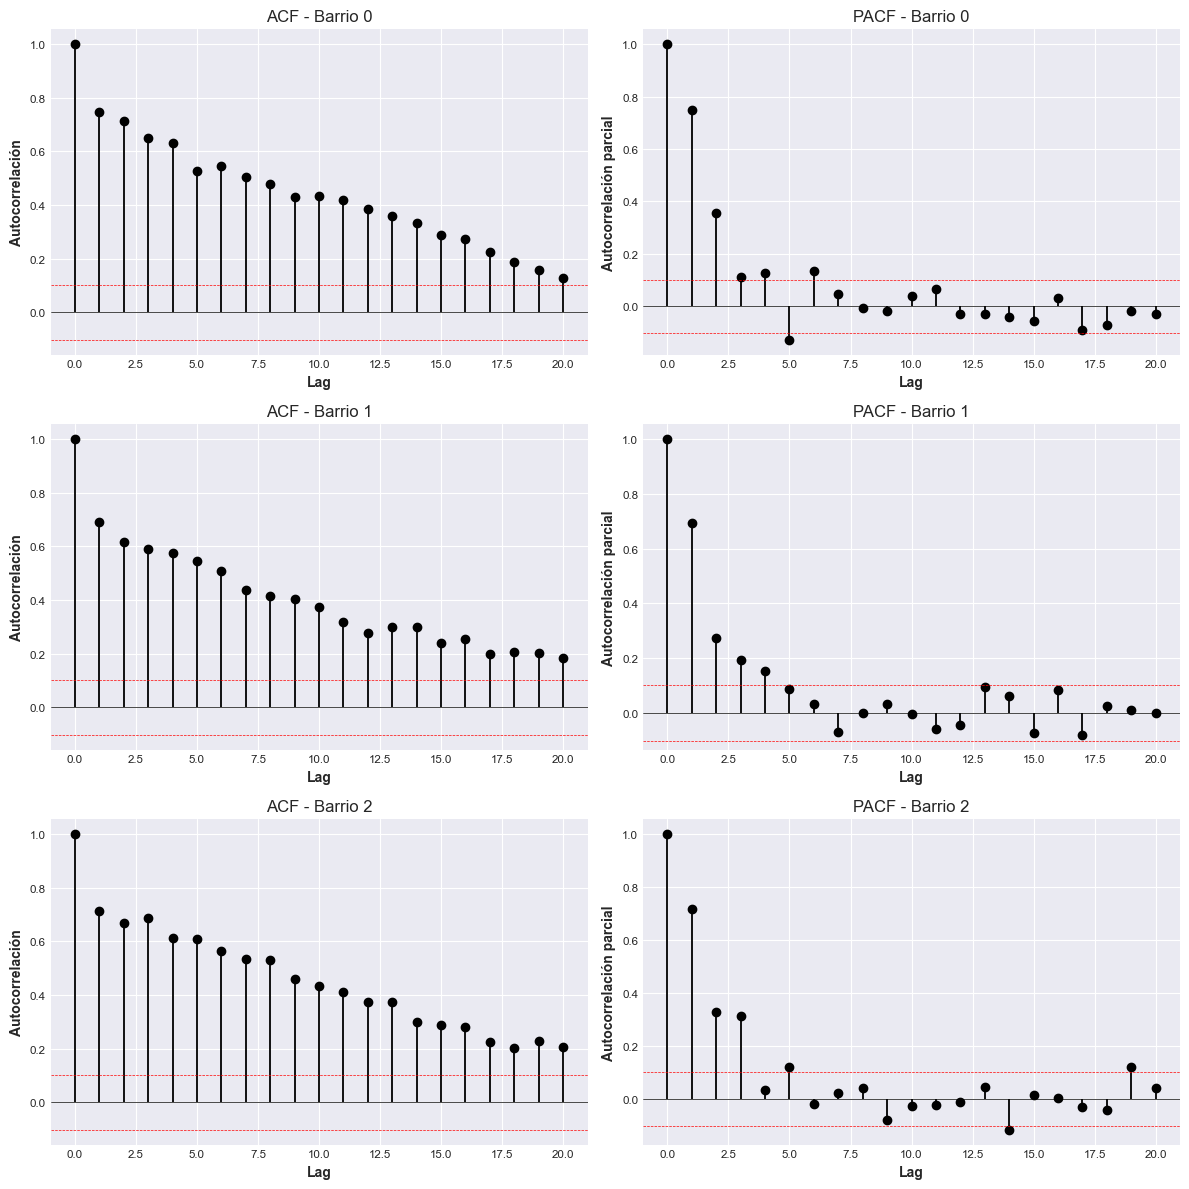


CLUSTERING DE BARRIOS POR PATRÓN TEMPORAL

🎯 Estadísticas por cluster:
         count  mean   std     sum
cluster                           
0          368  2.67  3.25   982.0
1         2208  2.49  3.38  5487.0
2          368  3.32  4.33  1220.0
3          368  2.35  3.10   865.0
4          368  2.85  4.03  1049.0


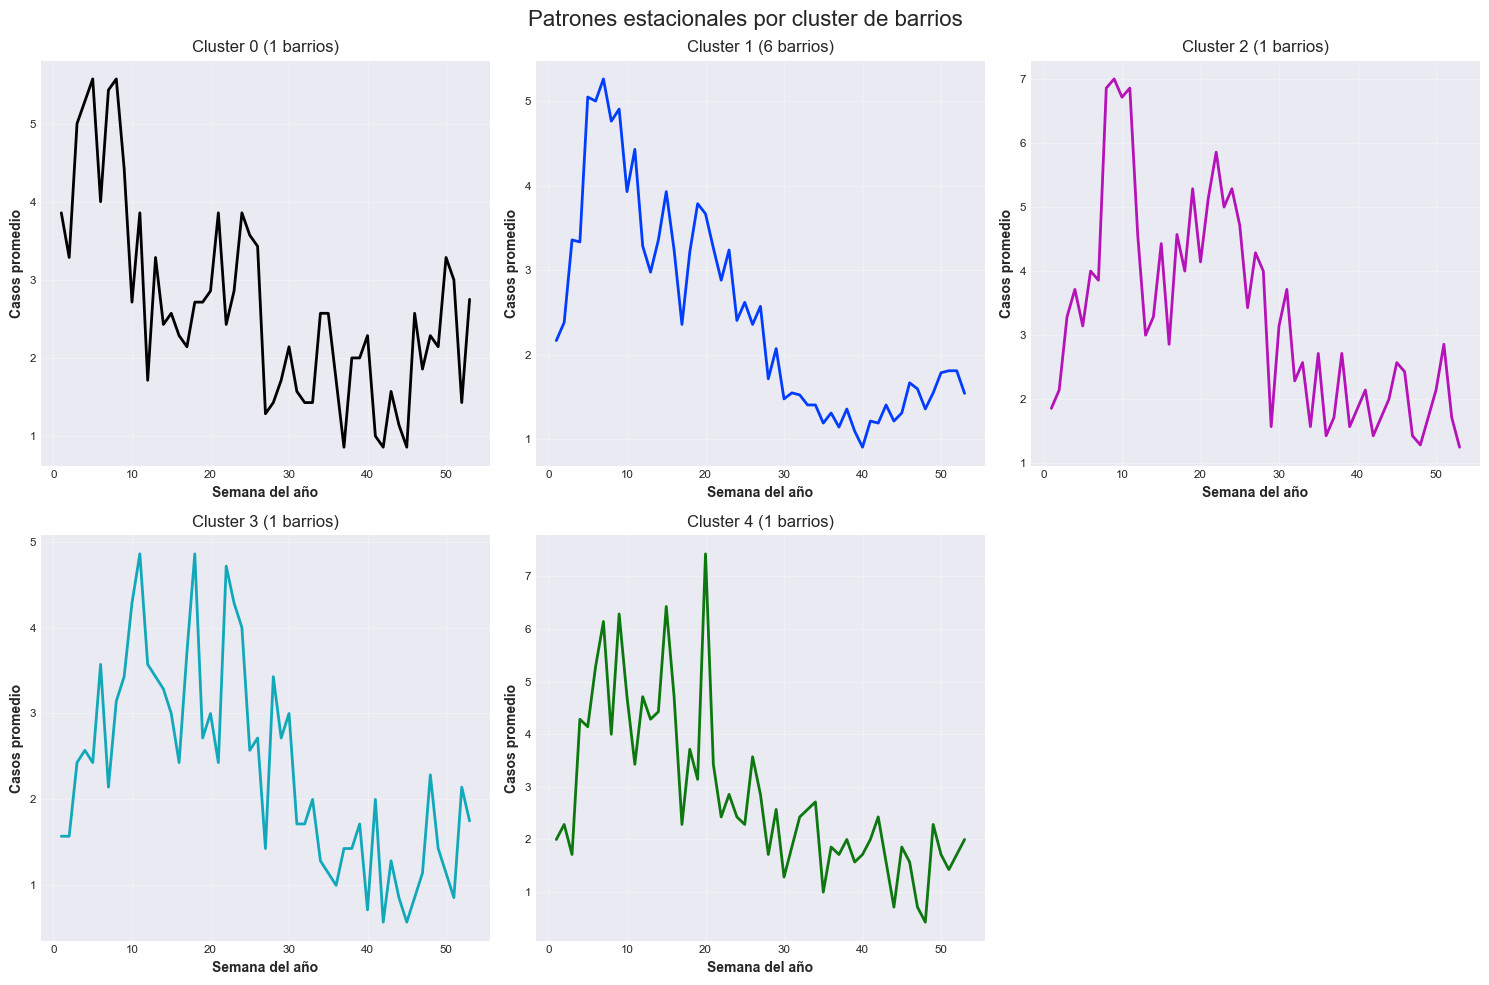

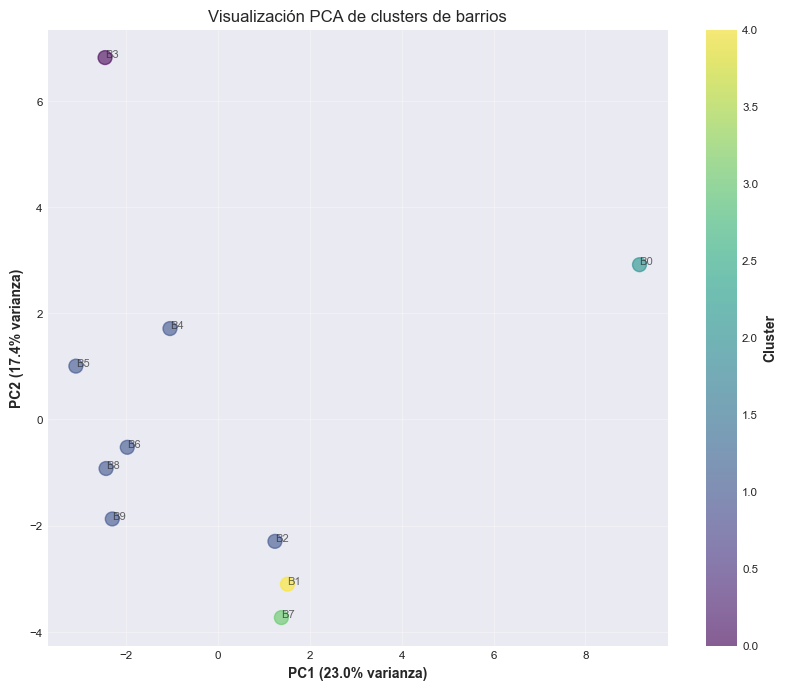


ANÁLISIS DE VENTANAS TEMPORALES ÓPTIMAS


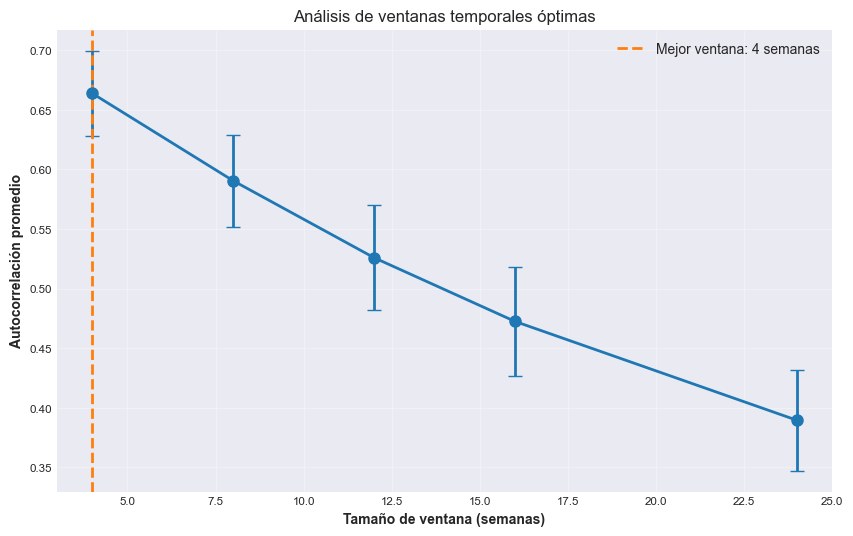


📊 Resumen de análisis de ventanas:
    mean_acf  std_acf  n_barrios
4      0.664    0.036       10.0
8      0.591    0.039       10.0
12     0.526    0.044       10.0
16     0.473    0.046       10.0
24     0.390    0.042       10.0

✅ Ventana óptima general: 4 semanas

📊 Ventanas óptimas por cluster de barrios:
   Cluster 1: 4 semanas
   Cluster 0: 4 semanas
   Cluster 4: 4 semanas
   Cluster 3: 4 semanas
   Cluster 2: 4 semanas

ANÁLISIS DE IMPORTANCIA DE VARIABLES

📊 Correlación con dengue:
temperatura_min     0.186
temperatura_mean    0.128
sumideros           0.107
equipesado          0.075
area_barrio         0.056
maquina             0.012
temperatura_max    -0.000
ESTRATO            -0.018
vivienda           -0.024
concentraciones    -0.037
lluvia_max         -0.047
temperatura_var    -0.048
lluvia_var         -0.088
lluvia_mean        -0.108
lluvia_min            NaN
Name: dengue, dtype: float64

📊 Información mutua:
             feature  mi_score
11  temperatura_mean     0.2

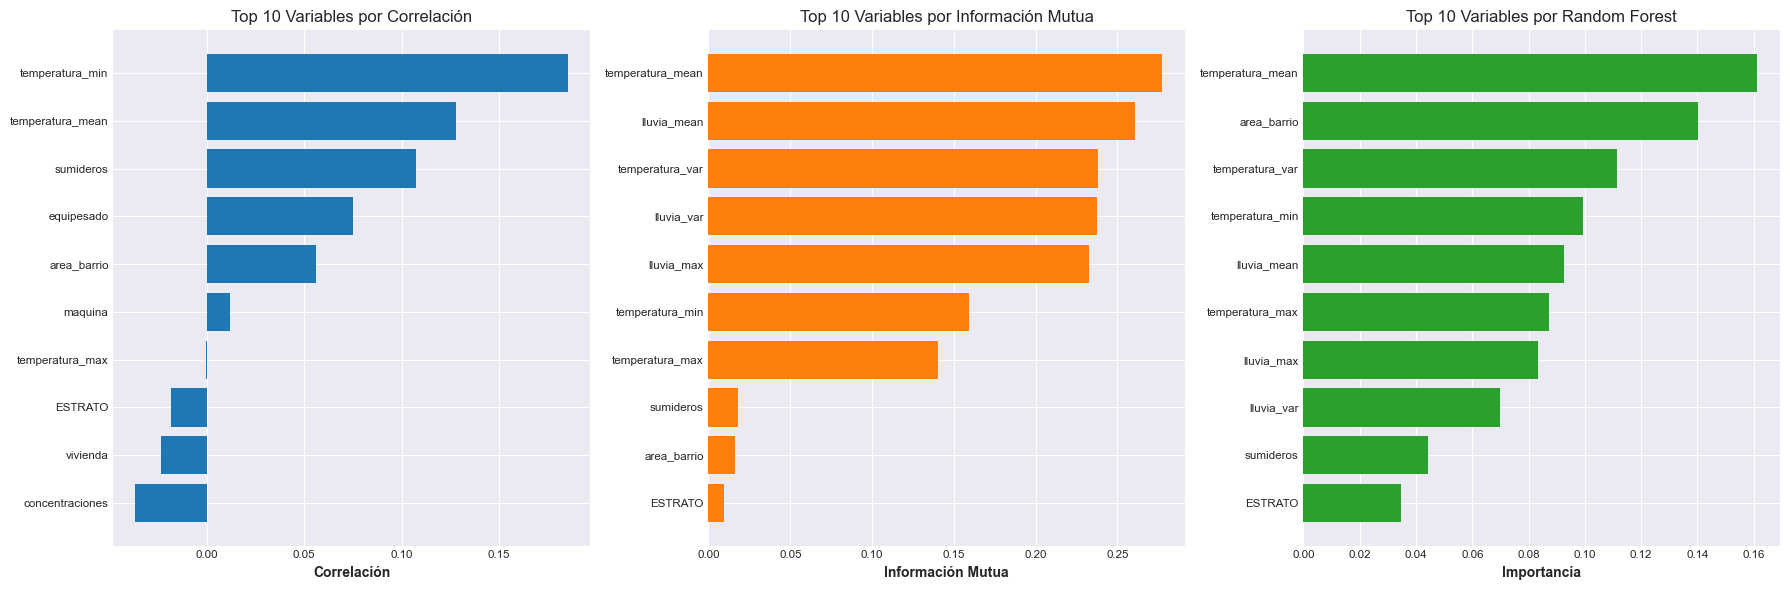

TypeError: tri() missing 1 required positional argument: 'N'

<Figure size 1200x1000 with 0 Axes>

In [2]:
# ===========================================================================================
# SECCIÓN 1: IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN
# ===========================================================================================

"""
Sistema de predicción de brotes de dengue en Cali, Colombia
Utilizando redes neuronales GRU con PyTorch y DARTS
Autor: Sistema de IA
Fecha: 2025
"""

# Librerías estándar de Python
import os
import warnings
import pickle
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Union

# Librerías para manejo de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Librerías para análisis estadístico
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Librerías para machine learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Librerías para deep learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Librería DARTS para series temporales
from darts import TimeSeries
#from darts.models import GRUModel
from darts.metrics import mse, mae, mape
from darts.dataprocessing.transformers import Scaler

# Librería para optimización de hiperparámetros
import optuna
from optuna.trial import Trial

# Configuración general
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

# Configuración de colores para visualizaciones
COLORS = {
    'primary': '#1f77b4',
    'secondary': '#ff7f0e',
    'tertiary': '#2ca02c',
    'quaternary': '#d62728',
    'quinary': '#9467bd'
}

# Configuración de semillas para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Configuración de dispositivo (GPU/CPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo configurado: {DEVICE}")
print(f"GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU detectada: {torch.cuda.get_device_name(0)}")

# Rutas de archivos
DATA_DIR = "../../Datos"
TRAIN_FILE = os.path.join(DATA_DIR, "df_train.parquet")
TEST_FILE = os.path.join(DATA_DIR, "df_test.parquet")
SUBMISSION_FILE = os.path.join(DATA_DIR, "sample_submission.csv")

# ===========================================================================================
# SECCIÓN 2: CARGA Y EXPLORACIÓN INICIAL DE DATOS
# ===========================================================================================

def load_data(verbose: bool = True) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Carga los datasets de entrenamiento, test y submission.
    
    Parameters:
    -----------
    verbose : bool
        Si True, imprime información sobre los datasets cargados
        
    Returns:
    --------
    tuple : (df_train, df_test, df_submission)
        DataFrames con los datos cargados
    """
    print("="*80)
    print("CARGA DE DATOS")
    print("="*80)
    
    # Cargar archivos
    df_train = pd.read_parquet(TRAIN_FILE)
    df_test = pd.read_parquet(TEST_FILE)
    df_submission = pd.read_csv(SUBMISSION_FILE)
    
    if verbose:
        print(f"\n📊 Dimensiones de los datasets:")
        print(f"   - Train: {df_train.shape} ({df_train.shape[0]:,} registros, {df_train.shape[1]} columnas)")
        print(f"   - Test: {df_test.shape} ({df_test.shape[0]:,} registros, {df_test.shape[1]} columnas)")
        print(f"   - Submission: {df_submission.shape}")
        
        print(f"\n📅 Rango temporal:")
        print(f"   - Train: {df_train['anio'].min()} - {df_train['anio'].max()}")
        print(f"   - Test: {df_test['anio'].min()} - {df_test['anio'].max()}")
        
        print(f"\n🏘️  Número de barrios:")
        print(f"   - Train: {df_train['id_bar'].nunique()} barrios únicos")
        print(f"   - Test: {df_test['id_bar'].nunique()} barrios únicos")
        
        # Verificar columnas
        print("\n📋 Columnas en train:")
        print(f"   {list(df_train.columns)}")
        
        print("\n📋 Columnas en test:")
        print(f"   {list(df_test.columns)}")
        
        # Verificar valores faltantes
        print("\n❓ Valores faltantes en train:")
        missing_train = df_train.isnull().sum()
        if missing_train.sum() > 0:
            print(missing_train[missing_train > 0])
        else:
            print("   No hay valores faltantes")
            
        print("\n❓ Valores faltantes en test:")
        missing_test = df_test.isnull().sum()
        if missing_test.sum() > 0:
            print(missing_test[missing_test > 0])
        else:
            print("   No hay valores faltantes")
    
    return df_train, df_test, df_submission

# Cargar los datos
df_train, df_test, df_submission = load_data()

# Exploración básica adicional
def explore_basic_stats(df: pd.DataFrame, name: str = "Dataset") -> None:
    """
    Muestra estadísticas descriptivas básicas del dataset.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame a explorar
    name : str
        Nombre del dataset para el título
    """
    print(f"\n📊 Estadísticas descriptivas - {name}")
    print("="*80)
    
    # Seleccionar solo columnas numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Estadísticas básicas
    stats_df = df[numeric_cols].describe().round(2)
    print(stats_df)
    
    # Información adicional sobre la variable objetivo
    if 'dengue' in df.columns:
        print(f"\n🦟 Análisis de la variable objetivo (dengue):")
        print(f"   - Total de casos: {df['dengue'].sum():,.0f}")
        print(f"   - Promedio por registro: {df['dengue'].mean():.2f}")
        print(f"   - Mediana: {df['dengue'].median():.2f}")
        print(f"   - Desviación estándar: {df['dengue'].std():.2f}")
        print(f"   - Valores únicos: {df['dengue'].nunique()}")
        print(f"   - Porcentaje de ceros: {(df['dengue'] == 0).mean() * 100:.1f}%")

explore_basic_stats(df_train, "Train")

# ===========================================================================================
# SECCIÓN 3: ANÁLISIS EXPLORATORIO ENFOCADO EN SERIES DE TIEMPO
# ===========================================================================================

def analyze_temporal_patterns(df: pd.DataFrame) -> Dict:
    """
    Analiza patrones temporales en los datos de dengue.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con los datos
        
    Returns:
    --------
    dict : Diccionario con resultados del análisis
    """
    print("\n" + "="*80)
    print("ANÁLISIS DE PATRONES TEMPORALES")
    print("="*80)
    
    # Crear columna de fecha para facilitar análisis
    df['fecha'] = pd.to_datetime(df['anio'].astype(str) + '-W' + 
                                df['semana'].astype(str).str.zfill(2) + '-1', 
                                format='%Y-W%W-%w')
    
    # Análisis global de dengue por tiempo
    dengue_temporal = df.groupby('fecha')['dengue'].agg(['sum', 'mean', 'std']).reset_index()
    
    # Crear visualización de evolución temporal global
    fig = make_subplots(rows=2, cols=1, 
                       subplot_titles=('Casos totales de dengue por semana',
                                     'Promedio de casos por barrio'),
                       vertical_spacing=0.1)
    
    # Gráfico de casos totales
    fig.add_trace(go.Scatter(x=dengue_temporal['fecha'],
                            y=dengue_temporal['sum'],
                            mode='lines',
                            name='Casos totales',
                            line=dict(color=COLORS['primary'], width=2)),
                 row=1, col=1)
    
    # Gráfico de promedio con banda de confianza
    fig.add_trace(go.Scatter(x=dengue_temporal['fecha'],
                            y=dengue_temporal['mean'],
                            mode='lines',
                            name='Promedio',
                            line=dict(color=COLORS['secondary'], width=2)),
                 row=2, col=1)
    
    # Banda de confianza (±1 std)
    fig.add_trace(go.Scatter(x=dengue_temporal['fecha'],
                            y=dengue_temporal['mean'] + dengue_temporal['std'],
                            mode='lines',
                            name='Media + 1 std',
                            line=dict(width=0),
                            showlegend=False),
                 row=2, col=1)
    
    fig.add_trace(go.Scatter(x=dengue_temporal['fecha'],
                            y=dengue_temporal['mean'] - dengue_temporal['std'],
                            mode='lines',
                            name='Media - 1 std',
                            line=dict(width=0),
                            fill='tonexty',
                            fillcolor='rgba(255,127,14,0.2)',
                            showlegend=False),
                 row=2, col=1)
    
    fig.update_layout(height=800, title_text="Evolución temporal del dengue (2015-2021)")
    fig.update_xaxes(title_text="Fecha", row=2, col=1)
    fig.update_yaxes(title_text="Casos", row=1, col=1)
    fig.update_yaxes(title_text="Casos promedio", row=2, col=1)
    fig.show()
    
    # Análisis por año
    yearly_stats = df.groupby('anio')['dengue'].agg(['sum', 'mean', 'std'])
    print("\n📅 Estadísticas por año:")
    print(yearly_stats.round(2))
    
    # Análisis estacional (por semana del año)
    seasonal_pattern = df.groupby('semana')['dengue'].agg(['mean', 'std'])
    
    # Visualizar patrón estacional
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(seasonal_pattern.index, seasonal_pattern['mean'], 
             color=COLORS['primary'], linewidth=2)
    plt.fill_between(seasonal_pattern.index,
                     seasonal_pattern['mean'] - seasonal_pattern['std'],
                     seasonal_pattern['mean'] + seasonal_pattern['std'],
                     alpha=0.3, color=COLORS['primary'])
    plt.xlabel('Semana del año')
    plt.ylabel('Casos promedio de dengue')
    plt.title('Patrón estacional del dengue')
    plt.grid(True, alpha=0.3)
    
    # Boxplot por semana
    plt.subplot(1, 2, 2)
    df.boxplot(column='dengue', by='semana', ax=plt.gca(), patch_artist=True)
    plt.xlabel('Semana del año')
    plt.ylabel('Casos de dengue')
    plt.title('Distribución de casos por semana')
    plt.suptitle('')  # Quitar título automático del boxplot
    
    plt.tight_layout()
    plt.show()
    
    return {
        'temporal_data': dengue_temporal,
        'yearly_stats': yearly_stats,
        'seasonal_pattern': seasonal_pattern
    }

# Ejecutar análisis temporal
temporal_analysis = analyze_temporal_patterns(df_train)

def analyze_by_neighborhood(df: pd.DataFrame, top_n: int = 10) -> Dict:
    """
    Analiza patrones de dengue por barrio.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con los datos
    top_n : int
        Número de barrios top a analizar en detalle
        
    Returns:
    --------
    dict : Diccionario con resultados del análisis por barrio
    """
    print("\n" + "="*80)
    print("ANÁLISIS POR BARRIO")
    print("="*80)
    
    # Estadísticas por barrio
    barrio_stats = df.groupby('id_bar')['dengue'].agg([
        'count', 'sum', 'mean', 'std', 'min', 'max'
    ]).round(2)
    
    # Ordenar por total de casos
    barrio_stats = barrio_stats.sort_values('sum', ascending=False)
    
    print(f"\n🏘️  Top {top_n} barrios con más casos de dengue:")
    print(barrio_stats.head(top_n))
    
    # Visualizar top barrios
    top_barrios = barrio_stats.head(top_n).index
    
    fig = go.Figure()
    
    for i, barrio in enumerate(top_barrios):
        barrio_data = df[df['id_bar'] == barrio].sort_values('fecha')
        
        fig.add_trace(go.Scatter(
            x=barrio_data['fecha'],
            y=barrio_data['dengue'],
            mode='lines',
            name=f'Barrio {barrio}',
            line=dict(width=2),
            opacity=0.8
        ))
    
    fig.update_layout(
        title=f'Evolución temporal del dengue - Top {top_n} barrios',
        xaxis_title='Fecha',
        yaxis_title='Casos de dengue',
        height=600,
        hovermode='x unified'
    )
    fig.show()
    
    # Análisis de autocorrelación para top barrios
    print(f"\n📊 Análisis de autocorrelación para top {min(3, top_n)} barrios:")
    
    fig, axes = plt.subplots(min(3, top_n), 2, figsize=(12, 4*min(3, top_n)))
    if min(3, top_n) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, barrio in enumerate(top_barrios[:min(3, top_n)]):
        barrio_series = df[df['id_bar'] == barrio].sort_values('fecha')['dengue'].values
        
        # ACF
        acf_values = acf(barrio_series, nlags=20)
        axes[idx, 0].stem(range(len(acf_values)), acf_values, basefmt=' ')
        axes[idx, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        axes[idx, 0].axhline(y=1.96/np.sqrt(len(barrio_series)), color='red', 
                            linestyle='--', linewidth=0.5)
        axes[idx, 0].axhline(y=-1.96/np.sqrt(len(barrio_series)), color='red', 
                            linestyle='--', linewidth=0.5)
        axes[idx, 0].set_title(f'ACF - Barrio {barrio}')
        axes[idx, 0].set_xlabel('Lag')
        axes[idx, 0].set_ylabel('Autocorrelación')
        
        # PACF
        pacf_values = pacf(barrio_series, nlags=20)
        axes[idx, 1].stem(range(len(pacf_values)), pacf_values, basefmt=' ')
        axes[idx, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        axes[idx, 1].axhline(y=1.96/np.sqrt(len(barrio_series)), color='red', 
                            linestyle='--', linewidth=0.5)
        axes[idx, 1].axhline(y=-1.96/np.sqrt(len(barrio_series)), color='red', 
                            linestyle='--', linewidth=0.5)
        axes[idx, 1].set_title(f'PACF - Barrio {barrio}')
        axes[idx, 1].set_xlabel('Lag')
        axes[idx, 1].set_ylabel('Autocorrelación parcial')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'barrio_stats': barrio_stats,
        'top_barrios': top_barrios
    }

# Ejecutar análisis por barrio
barrio_analysis = analyze_by_neighborhood(df_train)

def cluster_neighborhoods_by_pattern(df: pd.DataFrame, n_clusters: int = 5) -> Dict:
    """
    Agrupa barrios según sus patrones temporales de dengue.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con los datos
    n_clusters : int
        Número de clusters a formar
        
    Returns:
    --------
    dict : Diccionario con resultados del clustering
    """
    print("\n" + "="*80)
    print("CLUSTERING DE BARRIOS POR PATRÓN TEMPORAL")
    print("="*80)
    
    # Crear matriz de características por barrio
    # Usaremos promedios por semana del año para capturar estacionalidad
    barrio_patterns = df.pivot_table(
        values='dengue',
        index='id_bar',
        columns='semana',
        aggfunc='mean',
        fill_value=0
    )
    
    # Normalizar patrones
    scaler = StandardScaler()
    patterns_scaled = scaler.fit_transform(barrio_patterns)
    
    # Aplicar K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED)
    clusters = kmeans.fit_predict(patterns_scaled)
    
    # Añadir clusters al dataframe
    barrio_clusters = pd.DataFrame({
        'id_bar': barrio_patterns.index,
        'cluster': clusters
    })
    
    # Estadísticas por cluster
    df_with_clusters = df.merge(barrio_clusters, on='id_bar')
    cluster_stats = df_with_clusters.groupby('cluster')['dengue'].agg([
        'count', 'mean', 'std', 'sum'
    ]).round(2)
    
    print("\n🎯 Estadísticas por cluster:")
    print(cluster_stats)
    
    # Visualizar patrones promedio por cluster
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for cluster_id in range(n_clusters):
        cluster_barrios = barrio_clusters[barrio_clusters['cluster'] == cluster_id]['id_bar']
        cluster_data = df[df['id_bar'].isin(cluster_barrios)]
        
        # Patrón promedio del cluster
        cluster_pattern = cluster_data.groupby('semana')['dengue'].mean()
        
        axes[cluster_id].plot(cluster_pattern.index, cluster_pattern.values,
                             linewidth=2, color=f'C{cluster_id}')
        axes[cluster_id].set_title(f'Cluster {cluster_id} ({len(cluster_barrios)} barrios)')
        axes[cluster_id].set_xlabel('Semana del año')
        axes[cluster_id].set_ylabel('Casos promedio')
        axes[cluster_id].grid(True, alpha=0.3)
    
    # Ocultar ejes sobrantes
    for i in range(n_clusters, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Patrones estacionales por cluster de barrios', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Visualización PCA de los clusters
    pca = PCA(n_components=2)
    patterns_pca = pca.fit_transform(patterns_scaled)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(patterns_pca[:, 0], patterns_pca[:, 1], 
                         c=clusters, cmap='viridis', s=100, alpha=0.6)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
    plt.title('Visualización PCA de clusters de barrios')
    
    # Añadir etiquetas para algunos barrios
    top_barrios_idx = barrio_analysis['barrio_stats'].head(10).index
    for idx, barrio in enumerate(barrio_patterns.index):
        if barrio in top_barrios_idx:
            plt.annotate(f'B{barrio}', (patterns_pca[idx, 0], patterns_pca[idx, 1]),
                        fontsize=8, alpha=0.7)
    
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'barrio_clusters': barrio_clusters,
        'cluster_stats': cluster_stats,
        'patterns_pca': patterns_pca,
        'kmeans_model': kmeans
    }

# Ejecutar clustering
clustering_results = cluster_neighborhoods_by_pattern(df_train)

def analyze_optimal_window_sizes(df: pd.DataFrame, 
                               window_sizes: List[int] = [4, 8, 12, 16, 24]) -> Dict:
    """
    Analiza ventanas temporales óptimas para predicción.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con los datos
    window_sizes : List[int]
        Lista de tamaños de ventana a evaluar
        
    Returns:
    --------
    dict : Diccionario con resultados del análisis
    """
    print("\n" + "="*80)
    print("ANÁLISIS DE VENTANAS TEMPORALES ÓPTIMAS")
    print("="*80)
    
    results = {}
    
    # Para cada tamaño de ventana, evaluar autocorrelación promedio
    for window in window_sizes:
        acf_scores = []
        
        # Evaluar para cada barrio
        for barrio in df['id_bar'].unique()[:20]:  # Limitar a 20 barrios para eficiencia
            barrio_data = df[df['id_bar'] == barrio].sort_values('fecha')['dengue'].values
            
            if len(barrio_data) > window:
                # Calcular autocorrelación hasta el lag especificado
                acf_values = acf(barrio_data, nlags=window, fft=True)
                # Tomar el promedio de autocorrelaciones significativas
                significant_acf = np.abs(acf_values[1:]) > 1.96/np.sqrt(len(barrio_data))
                if significant_acf.any():
                    acf_scores.append(np.mean(np.abs(acf_values[1:][significant_acf])))
        
        if acf_scores:
            results[window] = {
                'mean_acf': np.mean(acf_scores),
                'std_acf': np.std(acf_scores),
                'n_barrios': len(acf_scores)
            }
    
    # Visualizar resultados
    window_df = pd.DataFrame(results).T
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(window_df.index, window_df['mean_acf'], 
                yerr=window_df['std_acf'], 
                marker='o', markersize=8, capsize=5,
                linewidth=2, color=COLORS['primary'])
    plt.xlabel('Tamaño de ventana (semanas)')
    plt.ylabel('Autocorrelación promedio')
    plt.title('Análisis de ventanas temporales óptimas')
    plt.grid(True, alpha=0.3)
    
    # Añadir línea de mejor ventana
    best_window = window_df['mean_acf'].idxmax()
    plt.axvline(x=best_window, color=COLORS['secondary'], 
               linestyle='--', linewidth=2, 
               label=f'Mejor ventana: {best_window} semanas')
    plt.legend()
    plt.show()
    
    print("\n📊 Resumen de análisis de ventanas:")
    print(window_df.round(3))
    print(f"\n✅ Ventana óptima general: {best_window} semanas")
    
    # Análisis por cluster
    print("\n📊 Ventanas óptimas por cluster de barrios:")
    df_with_clusters = df.merge(clustering_results['barrio_clusters'], on='id_bar')
    
    cluster_windows = {}
    for cluster_id in df_with_clusters['cluster'].unique():
        cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
        
        # Evaluar autocorrelación promedio para este cluster
        best_acf = 0
        best_window_cluster = window_sizes[0]
        
        for window in window_sizes:
            acf_scores = []
            for barrio in cluster_data['id_bar'].unique()[:10]:
                barrio_data = cluster_data[cluster_data['id_bar'] == barrio].sort_values('fecha')['dengue'].values
                if len(barrio_data) > window:
                    acf_val = np.mean(np.abs(acf(barrio_data, nlags=window, fft=True)[1:]))
                    acf_scores.append(acf_val)
            
            if acf_scores and np.mean(acf_scores) > best_acf:
                best_acf = np.mean(acf_scores)
                best_window_cluster = window
        
        cluster_windows[cluster_id] = best_window_cluster
        print(f"   Cluster {cluster_id}: {best_window_cluster} semanas")
    
    return {
        'window_analysis': window_df,
        'best_window': best_window,
        'cluster_windows': cluster_windows
    }

# Ejecutar análisis de ventanas
window_analysis = analyze_optimal_window_sizes(df_train)

# ===========================================================================================
# SECCIÓN 4: ANÁLISIS DE VARIABLES Y FEATURE ENGINEERING
# ===========================================================================================

def analyze_feature_importance(df: pd.DataFrame) -> Dict:
    """
    Analiza la importancia de las variables para predecir dengue.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con los datos
        
    Returns:
    --------
    dict : Diccionario con resultados del análisis
    """
    print("\n" + "="*80)
    print("ANÁLISIS DE IMPORTANCIA DE VARIABLES")
    print("="*80)
    
    # Seleccionar features numéricos (excluyendo identificadores y target)
    feature_cols = [col for col in df.columns if col not in 
                   ['id', 'id_bar', 'anio', 'semana', 'dengue', 'fecha', '__index_level_0__']]
    
    X = df[feature_cols].fillna(0)
    y = df['dengue']
    
    # 1. Correlación de Pearson
    correlations = df[feature_cols + ['dengue']].corr()['dengue'].drop('dengue').sort_values(ascending=False)
    
    print("\n📊 Correlación con dengue:")
    print(correlations.round(3))
    
    # 2. Información mutua
    mi_scores = mutual_info_regression(X, y, random_state=RANDOM_SEED)
    mi_df = pd.DataFrame({
        'feature': feature_cols,
        'mi_score': mi_scores
    }).sort_values('mi_score', ascending=False)
    
    print("\n📊 Información mutua:")
    print(mi_df.round(3))
    
    # 3. Random Forest feature importance
    rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
    rf.fit(X, y)
    
    rf_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n📊 Importancia Random Forest:")
    print(rf_importance.round(3))
    
    # Visualización comparativa
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Correlación
    axes[0].barh(correlations.index[:10], correlations.values[:10], color=COLORS['primary'])
    axes[0].set_xlabel('Correlación')
    axes[0].set_title('Top 10 Variables por Correlación')
    axes[0].invert_yaxis()
    
    # Información mutua
    axes[1].barh(mi_df['feature'][:10], mi_df['mi_score'][:10], color=COLORS['secondary'])
    axes[1].set_xlabel('Información Mutua')
    axes[1].set_title('Top 10 Variables por Información Mutua')
    axes[1].invert_yaxis()
    
    # Random Forest
    axes[2].barh(rf_importance['feature'][:10], rf_importance['importance'][:10], 
                color=COLORS['tertiary'])
    axes[2].set_xlabel('Importancia')
    axes[2].set_title('Top 10 Variables por Random Forest')
    axes[2].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    # Matriz de correlación completa
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlations.index.shape[0]), k=1)
    
    corr_matrix = df[feature_cols + ['dengue']].corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": .8})
    plt.title('Matriz de Correlación de Variables', fontsize=16)
    plt.show()
    
    return {
        'correlations': correlations,
        'mutual_info': mi_df,
        'rf_importance': rf_importance,
        'rf_model': rf
    }

# Ejecutar análisis de importancia
importance_analysis = analyze_feature_importance(df_train)

def check_multicollinearity(df: pd.DataFrame) -> pd.DataFrame:
    """
    Verifica multicolinealidad usando VIF (Variance Inflation Factor).
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con los datos
        
    Returns:
    --------
    pd.DataFrame : DataFrame con valores VIF
    """
    print("\n" + "="*80)
    print("ANÁLISIS DE MULTICOLINEALIDAD (VIF)")
    print("="*80)
    
    # Seleccionar features numéricos
    feature_cols = [col for col in df.columns if col not in 
                   ['id', 'id_bar', 'anio', 'semana', 'dengue', 'fecha', '__index_level_0__']]
    
    X = df[feature_cols].fillna(0)
    
    # Calcular VIF para cada variable
    vif_data = pd.DataFrame()
    vif_data["Variable"] = feature_cols
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(feature_cols))]
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    print("\n📊 Valores VIF (>10 indica alta multicolinealidad):")
    print(vif_data.round(2))
    
    # Visualización
    plt.figure(figsize=(10, 6))
    colors = ['red' if vif > 10 else 'orange' if vif > 5 else 'green' for vif in vif_data['VIF']]
    plt.barh(vif_data['Variable'], vif_data['VIF'], color=colors)
    plt.axvline(x=10, color='red', linestyle='--', label='VIF = 10 (Alta multicolinealidad)')
    plt.axvline(x=5, color='orange', linestyle='--', label='VIF = 5 (Multicolinealidad moderada)')
    plt.xlabel('VIF')
    plt.title('Análisis de Multicolinealidad - Variance Inflation Factor')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return vif_data

# Ejecutar análisis VIF
vif_results = check_multicollinearity(df_train)

def create_engineered_features(df: pd.DataFrame, 
                              lag_weeks: List[int] = [1, 2, 4, 8, 12]) -> pd.DataFrame:
    """
    Crea nuevas características basadas en transformaciones y lags.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame original
    lag_weeks : List[int]
        Semanas de retraso para crear variables lag
        
    Returns:
    --------
    pd.DataFrame : DataFrame con nuevas características
    """
    print("\n" + "="*80)
    print("FEATURE ENGINEERING")
    print("="*80)
    
    df_eng = df.copy()
    
    # Asegurar que los datos estén ordenados
    df_eng = df_eng.sort_values(['id_bar', 'anio', 'semana'])
    
    print("🔧 Creando features temporales...")
    
    # 1. Variables lag de dengue (solo para train)
    if 'dengue' in df_eng.columns:
        for lag in lag_weeks:
            df_eng[f'dengue_lag_{lag}'] = df_eng.groupby('id_bar')['dengue'].shift(lag)
            print(f"   ✓ dengue_lag_{lag}")
    
    # 2. Medias móviles de variables climáticas
    climate_vars = ['lluvia_mean', 'lluvia_var', 'temperatura_mean', 'temperatura_var']
    window_sizes = [4, 8]  # Ventanas de 4 y 8 semanas
    
    for var in climate_vars:
        for window in window_sizes:
            # Media móvil
            df_eng[f'{var}_ma_{window}'] = df_eng.groupby('id_bar')[var].transform(
                lambda x: x.rolling(window=window, min_periods=1).mean()
            )
            print(f"   ✓ {var}_ma_{window}")
            
            # Desviación estándar móvil
            df_eng[f'{var}_std_{window}'] = df_eng.groupby('id_bar')[var].transform(
                lambda x: x.rolling(window=window, min_periods=1).std()
            )
    
    # 3. Diferencias y ratios
    print("\n🔧 Creando ratios y diferencias...")
    
    # Ratio lluvia/temperatura
    df_eng['lluvia_temp_ratio'] = df_eng['lluvia_mean'] / (df_eng['temperatura_mean'] + 1e-6)
    
    # Variabilidad relativa
    df_eng['lluvia_var_rel'] = df_eng['lluvia_var'] / (df_eng['lluvia_mean'] + 1e-6)
    df_eng['temp_var_rel'] = df_eng['temperatura_var'] / (df_eng['temperatura_mean'] + 1e-6)
    
    # Rango de temperatura
    df_eng['temp_range'] = df_eng['temperatura_max'] - df_eng['temperatura_min']
    
    # Rango de lluvia
    df_eng['lluvia_range'] = df_eng['lluvia_max'] - df_eng['lluvia_min']
    
    # 4. Interacciones entre variables socioeconómicas y ambientales
    print("\n🔧 Creando interacciones...")
    
    # Densidad de vivienda
    df_eng['densidad_vivienda'] = df_eng['vivienda'] / (df_eng['area_barrio'] + 1e-6)
    
    # Equipamiento per cápita
    df_eng['equipesado_per_capita'] = df_eng['equipesado'] / (df_eng['vivienda'] + 1e-6)
    
    # Sumideros por área
    df_eng['sumideros_por_area'] = df_eng['sumideros'] / (df_eng['area_barrio'] + 1e-6)
    
    # Interacción estrato-concentraciones
    df_eng['estrato_concentraciones'] = df_eng['ESTRATO'] * df_eng['concentraciones']
    
    # 5. Variables cíclicas para capturar estacionalidad
    print("\n🔧 Creando features cíclicos...")
    
    # Transformación seno/coseno de la semana del año
    df_eng['semana_sin'] = np.sin(2 * np.pi * df_eng['semana'] / 52)
    df_eng['semana_cos'] = np.cos(2 * np.pi * df_eng['semana'] / 52)
    
    # Indicador de temporada alta de dengue (basado en análisis previo)
    high_dengue_weeks = seasonal_pattern['mean'].nlargest(13).index  # Top 25% de semanas
    df_eng['temporada_alta'] = df_eng['semana'].isin(high_dengue_weeks).astype(int)
    
    # 6. Estadísticas del barrio (contexto)
    print("\n🔧 Agregando estadísticas del barrio...")
    
    if 'dengue' in df_eng.columns:
        # Promedio histórico de dengue por barrio
        barrio_avg = df_eng.groupby('id_bar')['dengue'].mean()
        df_eng['dengue_promedio_barrio'] = df_eng['id_bar'].map(barrio_avg)
        
        # Tendencia del barrio (alta/media/baja incidencia)
        percentiles = barrio_avg.quantile([0.33, 0.67])
        df_eng['tendencia_barrio'] = pd.cut(
            df_eng['dengue_promedio_barrio'],
            bins=[-np.inf, percentiles[0.33], percentiles[0.67], np.inf],
            labels=['baja', 'media', 'alta']
        )
    
    # Resumen de nuevas features
    new_features = [col for col in df_eng.columns if col not in df.columns]
    print(f"\n✅ Total de nuevas features creadas: {len(new_features)}")
    print(f"   Features originales: {len(df.columns)}")
    print(f"   Features totales: {len(df_eng.columns)}")
    
    return df_eng

# Aplicar feature engineering
df_train_eng = create_engineered_features(df_train, temporal_analysis['seasonal_pattern'])

# Guardar información de features para uso posterior
feature_info = {
    'original_features': [col for col in df_train.columns if col not in 
                         ['id', 'id_bar', 'anio', 'semana', 'dengue', 'fecha', '__index_level_0__']],
    'engineered_features': [col for col in df_train_eng.columns if col not in df_train.columns],
    'all_features': [col for col in df_train_eng.columns if col not in 
                    ['id', 'id_bar', 'anio', 'semana', 'dengue', 'fecha', '__index_level_0__', 
                     'tendencia_barrio', 'dengue_promedio_barrio']]
}

print("\n📊 Resumen de características:")
print(f"   - Features originales: {len(feature_info['original_features'])}")
print(f"   - Features ingenierizadas: {len(feature_info['engineered_features'])}")
print(f"   - Total features disponibles: {len(feature_info['all_features'])}")

# Visualizar algunas de las nuevas features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Ejemplo de barrio para visualización
example_barrio = barrio_analysis['top_barrios'][0]
barrio_data = df_train_eng[df_train_eng['id_bar'] == example_barrio].sort_values('fecha')

# 1. Variables lag
ax = axes[0, 0]
ax.plot(barrio_data['fecha'], barrio_data['dengue'], label='Dengue actual', linewidth=2)
ax.plot(barrio_data['fecha'], barrio_data['dengue_lag_1'], label='Lag 1 semana', alpha=0.7)
ax.plot(barrio_data['fecha'], barrio_data['dengue_lag_4'], label='Lag 4 semanas', alpha=0.7)
ax.set_title(f'Variables Lag de Dengue - Barrio {example_barrio}')
ax.set_xlabel('Fecha')
ax.set_ylabel('Casos')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Medias móviles climáticas
ax = axes[0, 1]
ax.plot(barrio_data['fecha'], barrio_data['lluvia_mean'], label='Lluvia original', alpha=0.5)
ax.plot(barrio_data['fecha'], barrio_data['lluvia_mean_ma_4'], label='MA 4 semanas', linewidth=2)
ax.plot(barrio_data['fecha'], barrio_data['lluvia_mean_ma_8'], label='MA 8 semanas', linewidth=2)
ax.set_title('Medias Móviles de Lluvia')
ax.set_xlabel('Fecha')
ax.set_ylabel('Lluvia promedio')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Ratios
ax = axes[1, 0]
ax.plot(barrio_data['fecha'], barrio_data['lluvia_temp_ratio'], 
        label='Ratio lluvia/temperatura', color=COLORS['tertiary'])
ax.set_title('Ratio Lluvia/Temperatura')
ax.set_xlabel('Fecha')
ax.set_ylabel('Ratio')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Features cíclicos
ax = axes[1, 1]
scatter = ax.scatter(barrio_data['semana_sin'], barrio_data['semana_cos'], 
                    c=barrio_data['semana'], cmap='hsv', s=50)
ax.set_title('Representación Cíclica de Semanas')
ax.set_xlabel('Seno(semana)')
ax.set_ylabel('Coseno(semana)')
ax.set_aspect('equal')
plt.colorbar(scatter, ax=ax, label='Semana del año')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Feature engineering completado!")
print("   Los datos ahora incluyen:")
print("   - Variables lag de dengue")
print("   - Medias móviles de variables climáticas")  
print("   - Ratios e interacciones entre variables")
print("   - Features cíclicos para estacionalidad")
print("   - Estadísticas contextuales por barrio")